**7장 – 앙상블 학습과 랜덤 포레스트**

_이 노트북은 7장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 투표기반 분류기

In [2]:
# 앙상블 : 모델의 결과를 평균, 다수의 결과 선택
# 큰수의 법칙

# 10000번 동전던지기, 10번수행
# 10개의 그래프

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
# 0.51보다작으면0  ..크면 1 (T/F-> integer로)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)
# 10000 * 10 2차원 배열
# cumsum : 차원을 따라 누적(행으로) 10000 * 10개로 유지되며 맨아래에 있는 행이 누적값
# 맨아래층에 5100 5099 ... : 51% 확률로 

**<그림 7-3. 큰 수의 법칙> 생성 코드**

그림 저장: law_of_large_numbers_plot


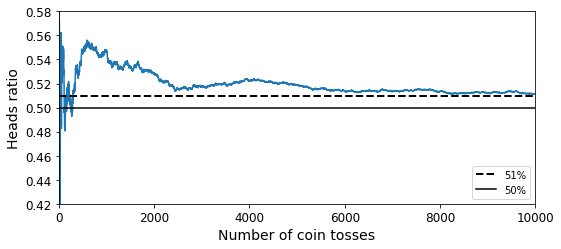

In [3]:
plt.figure(figsize=(8,3.5))
#plt.plot(cumulative_heads_ratio)
plt.plot(cumulative_heads_ratio[:,0]) # 하나만그리기
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()
# 처음에는 극단적인 케이스이지만 반복할수로 51프로에 수렴


moons 데이터셋을 사용해 보죠:

In [4]:
# make_moons

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# 샘플 500개 + noise
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**노트**: 향후 버전을 위해 사이킷런에서 기본 값이 될 `solver="lbfgs"`, `n_estimators=100`, `gamma="scale"`로 지정합니다.

**코드 예제:**

In [5]:
# VotingClassfier : 다수투표기반

from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], # 튜플형태
    voting='hard') # 예측한 클래스중 다수

In [6]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
from sklearn.metrics import accuracy_score # 정확도

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))    # clf.score(...)

# 정확도가 올라감

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [8]:
# 다른방법
for clf in voting_clf.estimators_ + [voting_clf]:
    print(clf.__class__.__name__, clf.score(X_test, y_test))  # 파이썬의 클래스 이름 얻기

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


**노트**: 사이킷런 알고리즘이 이따금 업데이트되기 때문에 이 노트북의 결과가 책과 조금 다를 수 있습니다.

간접 투표: hard 보다 더 나은 값을 도출할수 있음

In [9]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)
# svc는 확률값이 없어서 probability=true 로, 속도는 느려진다

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft') #'soft' 확률값 predict_proba()의 값을 평균해서 클래스 예측
voting_clf.fit(X_train, y_train)
# 각 분류기가 1/0에 대해 확률을 내서 어떤 클래스가 더 값이 높은지

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 배깅과 페이스팅

## 사이킷런의 배깅과 페이스팅

In [11]:
# bagging: bootstrapping aggregation
# 원래 샘플에 다시 넣어서 다시 꺼낸다.(한 샘플이 여러번 중복가능)
# 데이터셋에 무작위성 부여

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, # 기반모델, 500개 결정트리
    max_samples=100, bootstrap=True, random_state=42) # 100개씩 훈련
#    bootstrap=False : 페이스팅
#  max_samples=1.0 : 전체 샘플수만큼, 중복해서 선택하므로 데이터는 달라진다
#  max_samples=0.7 : 70%
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [13]:
# 결정트리 하나 : 85%
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


**<그림 7-5. 단일 경정 트리(왼쪽)와 500개 트리로 만든 배깅 앙상블(오른쪽) 비교> 생성 코드**

In [14]:
#결정경계 출력

from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
  # 2차원 평면에 전체 포인트 만들고 예측값 생성  
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap) # 컬러맵
    if contour: # 경계선
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

그림 저장: decision_tree_without_and_with_bagging_plot


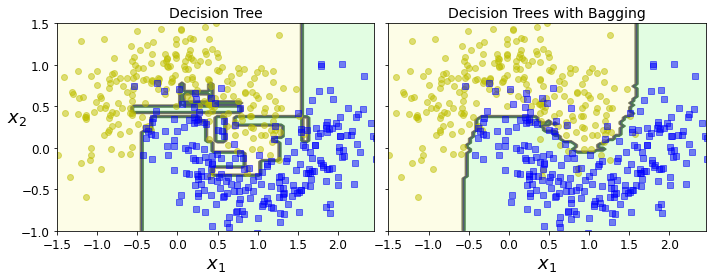

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()
# 결정트리 하나는 복잡한 경계
# 앙상블은 부드럽고 일반적인 경계

# 랜덤 포레스트

In [16]:
# 결정트리 배깅에서 과적합을 제한
# boostrap + 랜덤 특성 후보 선택

from sklearn.ensemble import RandomForestClassifier

# 특성을 랜덤하게 선택(sqrt(n_features))하고 노드분할
# 결정트리를 각각 훈련. n_jobs = -1 cpu코어를 각각 사용

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [17]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.976

랜덤 포레스트는 결정 트리의 배깅과 비슷합니다:

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [19]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [20]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 에측이 동일합니다.

1.0

## 특성 중요도

In [21]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
# feature_importances_
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)
    # 500개 트리의 특성 중요도를 평균

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [22]:
# 특성의 중요도만 출력
# 합이 1
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

다음 그림은 15개 결정 트리의 결정 경계를 중첩한 것입니다. 여기서 볼 수 있듯이 개별 결정 트리는 불완전하지만 앙상블되면 매우 좋은 결정 경계를 만듭니다:

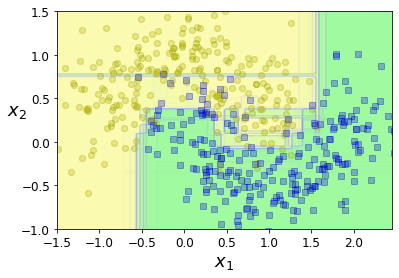

In [23]:
# 결정경계 수동 그리기

plt.figure(figsize=(6, 4))

for i in range(15): # 15개 결정트리
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train)) # 인덱스를 만들어 훈련세트 만들기
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

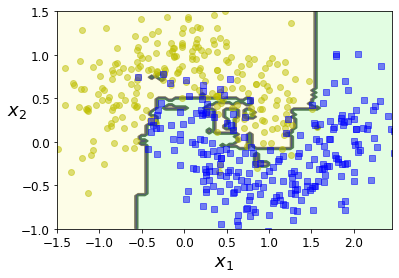

In [24]:
# 랜덤포레스트, 위의 15개와 유사
rf = RandomForestClassifier(n_estimators=15, random_state=42)
rf.fit(X_train, y_train)
plot_decision_boundary(rf, X, y, axes=[-1.5, 2.45, -1, 1.5])

plt.show()

In [25]:
# 훈련에 참여하지 않는 샘플로 모델의 성능평가
# oob_score=True : out of bag

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [26]:
# 결정함수 값
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

**<그림 7-6. (랜덤 포레스트 분류기에서 얻은) MNIST 픽셀 중요도> 생성 코드**

In [27]:
# 특성 중요도 : 픽셀의 중요도

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [28]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42) # 100개 결정트리
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [29]:
def plot_digit(data):
    image = data.reshape(28, 28) # reshape 해서 이미지로
    plt.imshow(image, cmap = mpl.cm.hot, # 검은색, 붉은색, 밝은노랑, 흰색(불꽃:히트맵)
               interpolation="nearest")
    plt.axis("off")

그림 저장: mnist_feature_importance_plot


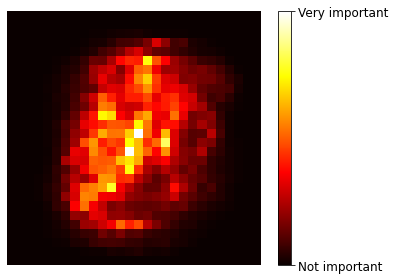

In [30]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()
# 픽셀값이 흰색이 중요한 값

# 부스팅

## 에이다부스트

In [31]:
# 에이다부스트 : 결정트리(max_depth=1)를 기본으로
# 첫번째 트리가 학습하고 에러(잘 못판단)샘플의 가중치를 높여준다. 
# 이를 반영하여 두번째 트리가 학습하고 이때 오류가 생긴 샘플의 가중치를 높여준다.


from sklearn.ensemble import AdaBoostClassifier

# AdaBoostRegressor --> DecisionTreeRegressor(max_depth=3)

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
 # "SAMME.R"(기본): 실수값 사용 (확률값이용)
 # learning_rate : 가중치 적용정도,  1(기본)일경우 동일한 가중치
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

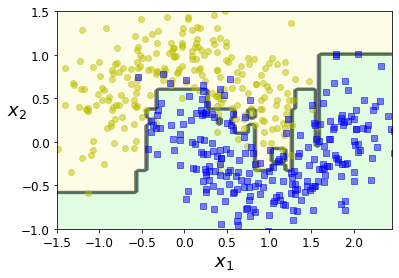

In [32]:
plot_decision_boundary(ada_clf, X, y)
# 반달모양 데이터셋을 대체로 잘 분류

**<그림 7-8. 연속된 예측기의 결정 경계> 생성 코드**

그림 저장: boosting_plot


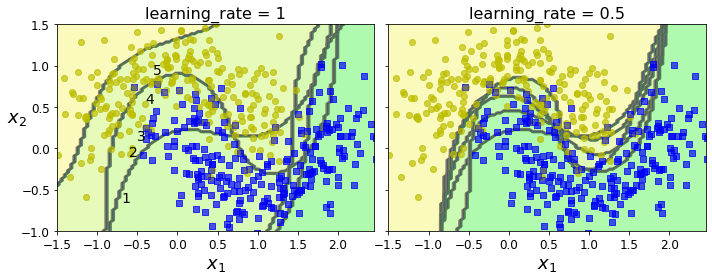

In [33]:
# 학습률에 따른 변화 실험

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)): # 학습률 1, 0.5
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42) # SVC, 
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m) #샘플 가중치
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        # 예측과 정답이 다른경우 weight를 높여준다
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

# left: 잘 못 만든 오차를 극복하기 위해 크게 변화 : 과대적합위험
# right:학습속도가 느리고 완만하게

# 그레이디언트 부스팅

간단한 이차식 형태의 데이터셋을 만들어 보죠:

In [34]:
# 에이다부스트 : 잘못예측한거를 수정하면서
# 그레디언트 : 오차를 고려하여
# -0.5~0.5 까지의 100개

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100) # 2차식 

이제 이 데이터셋에 결정 트리 회귀 모델을 훈련시킵니다:

In [35]:
from sklearn.tree import DecisionTreeRegressor

# 깊이가 2인 결정트리
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [36]:
y2 = y - tree_reg1.predict(X)  # 회귀모델의 오차 계산
# y2로 모델 만들기
# 타겟이 오차

tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [37]:
# 세번째 트리는 두번째 트리의 오차를 타겟으로

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [38]:
# 샘플만들어서 실험

X_new = np.array([[0.8]])

In [39]:
# 트리 3개에 대한 예측을 SUM

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [40]:
y_pred

array([0.75026781])

**<그림 7-9> 생성 코드**

In [41]:
# 그림그리기

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors) # for문에서 회귀모델이 돌면서 결과를 받아서 SUM
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

그림 저장: gradient_boosting_plot


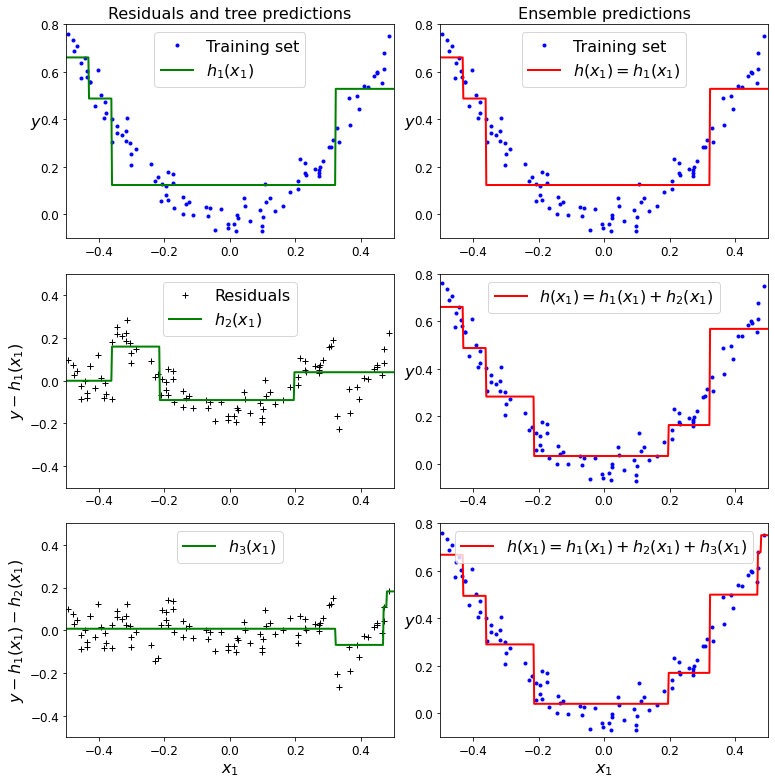

In [42]:
# 각 트리 그리기

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

# left : 두번째는 첫번째 트리 결과와 정답값의 오차
# right : 두번째는 첫번째 두번째의 앙상블


이제 그레이디언트 부스팅 회귀 모델을 사용해 보죠:

In [43]:
# 오차에 대해 학습
# 기반 트리를 DecisionTreeRegressor로 사용 (고정) : 회귀, 분류모두 회귀모델 사용
# 회귀모델 :loss='ls' (최소제곱) 미분 -> target-pred (경사값)
# 분류모델(GradientBoositngClassifier) : loss='deviance' (로지스틱 손실함수)

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
# max_depth=3, n_estimators=100 : 기본
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

**<그림 7-10. 예측기가 부족한 경우(왼쪽)과 너무 많은 경우(오른쪽)의 GBRT 앙상블> 생성 코드**

In [61]:
# 트리수 늘리고, 학습률 낮추어서 속도가 느려진다.
# 병렬적으로 작동하지 못하고 순차적으로

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

그림 저장: gbrt_learning_rate_plot


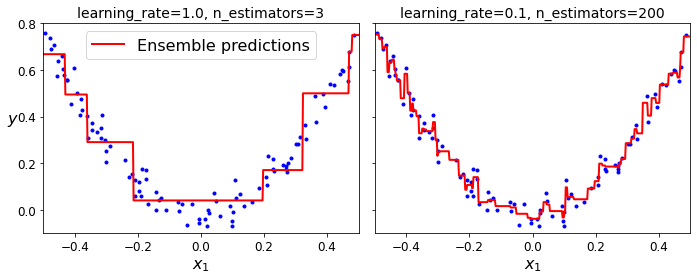

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

# left: 트리 3개
# right : 트리 200, 과대적합

**조기 종료를 사용한 그래디언트 부스팅**

In [46]:
# 조기종료

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

# 트리 120개
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) # MSE로 계산
          for y_pred in gbrt.staged_predict(X_val)] # 트리를 추가하면서 단계적 예측 값 출력
bst_n_estimators = np.argmin(errors) + 1 # 에러가 가장 작은 에러의 인덱스 찾기 : 0부터 시작하므로 +1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
# 오차가 가장 작을때 까지만 훈련
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

**<그림 7-11. 조기 종료를 사용하여 트리 수 튜닝> 생성 코드**

In [62]:
min_error = np.min(errors)

그림 저장: early_stopping_gbrt_plot


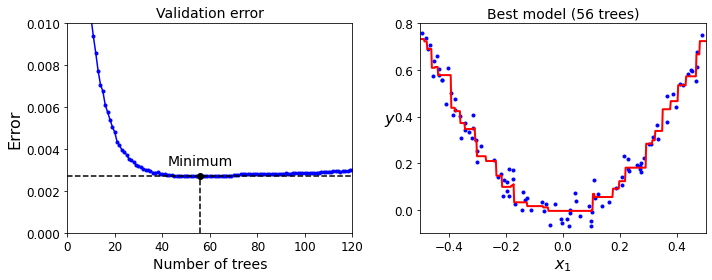

In [48]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

# 120까지 훈련하여 56이 가장 좋은 트리 갯수인거를 찾아냄
# 56개 트리 사용하여 과대적합 막을수 있다.

어느 정도 유예를 갖는 조기 종료(5 에포크 동안 향상되지 않을 때만 훈련 중지):

In [49]:
# warm_start=True
# 120개까지 훈련하는 중에 오차가 이전 오차의 최소오차보다 작은지 검사하여 5번 이상 작아지지 않으면 조기 종료
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:   # 5번 검사
            break  # early stopping

In [50]:
print(gbrt.n_estimators)

61


In [51]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


**XGBoost 사용하기**

In [52]:
# 히스토그램 방식
# 특성을 작은 갯수로 나누어서
# 코랩에 기본으로 설치되어있음
# pip install xgboost : 설치필요시

try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [53]:
if xgboost is not None:  # 책에 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42) #n_estimators =100, max_depth=3 : 기본값
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # 책에 없음
    print("Validation MSE:", val_error)           # 책에 없음
    # 빠르고 낮은 MSE 보임

[10:04:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


In [54]:
# early_stopping_rounds=2 : 트리 추가하는 반복횟수
# 부스팅이 횟수 2번 연속 검증에서 좋아지지 않으면 조기 종료

if xgboost is not None:  # 책에 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # 책에 없음
    print("Validation MSE:", val_error)            # 책에 없음

    # 검증세트 값 출력

[10:04:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse

In [55]:
#속도 측정

%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

[10:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [57]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

10 loops, best of 5: 22 ms per loop


In [59]:
# 히스토그램 기반
from lightgbm import LGBMRegressor

lgb_reg = LGBMRegressor(random_state=42)
lgb_reg.fit(X_train, y_train)

y_pred=lgb_reg.predict(X_val)
val_error =mean_squared_error(y_val, y_pred)
val_error

0.01777549654697777

In [60]:
%timeit LGBMRegressor().fit(X_train, y_train)
# xgbooster 보다 빠른속도, 성능 good
# 저수준 코드로 구현


100 loops, best of 5: 5.42 ms per loop


# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8. 투표 기반 분류기

문제: _MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다(예를 들면 훈련에 40,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플)._

MNIST 데이터셋은 앞에서 로드했습니다.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

문제: _그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 같은 여러 종류의 분류기를 훈련시킵니다._

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [ ]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [ ]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9666]

선형 SVM이 다른 분류기보다 성능이 많이 떨어집니다. 그러나 투표 기반 분류기의 성능을 향상시킬 수 있으므로 그대로 두겠습니다.

문제: _그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결해보세요._

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [ ]:
voting_clf = VotingClassifier(named_estimators)

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [ ]:
voting_clf.score(X_val, y_val)

0.9708

In [ ]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859, 0.9666]

SVM 모델을 제거해서 성능이 향상되는지 확인해 보죠. 다음과 같이 `set_params()`를 사용하여 `None`으로 지정하면 특정 예측기를  제외시킬 수 있습니다:

In [ ]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

예측기 목록이 업데이트되었습니다:

In [ ]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

하지만 훈련된 예측기 목록은 업데이트되지 않습니다:

In [ ]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

`VotingClassifier`를 다시 훈련시키거나 그냥 훈련된 예측기 목록에서 SVM 모델을 제거할 수 있습니다:

In [ ]:
del voting_clf.estimators_[2]

`VotingClassifier`를 다시 평가해 보죠:

In [ ]:
voting_clf.score(X_val, y_val)

0.9741

훨씬 나아졌네요! SVM 모델이 성능을 저하시켰습니다. 이제 간접 투표 분류기를 사용해 보죠. 분류기를 다시 훈련시킬 필요는 없고 `voting`을 `"soft"`로 지정하면 됩니다:

In [ ]:
voting_clf.voting = "soft"

In [ ]:
voting_clf.score(X_val, y_val)

0.972

이 경우는 직접 투표 방식이 낫네요.

_앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?_

In [ ]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.971

In [ ]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9643]

여기서는 투표 기반 분류기가 최선의 모델의 오차율을 아주 조금만 감소시킵니다.

## 9. 스태킹 앙상블

문제: _이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜 보세요._

In [ ]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [ ]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [ ]:
rnd_forest_blender.oob_score_

0.9707

이 블렌더를 세밀하게 튜닝하거나 다른 종류의 블렌더(예를 들어, `MLPClassifier`)를 시도해 볼 수 있습니다. 그런 늘 하던대로 다음 교차 검증을 사용해 가장 좋은 것을 선택합니다.

문제: _축하합니다. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다. 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?_

In [ ]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred)

0.9695

이 스태킹 앙상블은 앞서 만든 투표 기반 분류기만큼 성능을 내지는 못합니다. 최선의 개별 분류기만큼 뛰어나지는 않습니다.